<a href="https://www.kaggle.com/code/aryandec25/notebook-stackoverflow?scriptVersionId=135940007" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing all the required libraries

In [55]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/facebook-recruiting-iii-keyword-extraction/Train.zip
/kaggle/input/facebook-recruiting-iii-keyword-extraction/SampleSubmission.csv
/kaggle/input/facebook-recruiting-iii-keyword-extraction/Test.zip


In [2]:
!unzip /kaggle/input/facebook-recruiting-iii-keyword-extraction/Train.zip
!unzip /kaggle/input/facebook-recruiting-iii-keyword-extraction/Test.zip

Archive:  /kaggle/input/facebook-recruiting-iii-keyword-extraction/Train.zip
  inflating: Train.csv               
Archive:  /kaggle/input/facebook-recruiting-iii-keyword-extraction/Test.zip
  inflating: Test.csv                


In [3]:
df_train = pd.read_csv('/kaggle/working/Train.csv').sample(200000)
df_test = pd.read_csv('/kaggle/working/Test.csv').sample(200000)

# Exploring the data

In [4]:
print(f'The shape of the Train dataset: {df_train.shape}')
print(f'The shape of the Train dataset: {df_test.shape}')

The shape of the Train dataset: (200000, 4)
The shape of the Train dataset: (200000, 3)


In [5]:
df_train.head()

,Id,Title,Body,Tags
63845,63846,"Flex Builder - Profiler - Can't run profiler ""...",<p>I use Flex Builder 4 Plugin on Eclipse 3.6....,actionscript flex4 flexbuilder profiler
3524474,3524475,How to read the index of the color table/palle...,<p>I have a grayscale bitmap with 8bit indexed...,android bitmap bitmapimage grayscale
942250,942251,Include files from context differents How do I...,<p>I have a relative path to another context o...,java servlets struts
1047314,1047315,Create deployable JRuby JAR file?,<p>I need to compile my JRuby application into...,jruby executable-jar
21366,21367,Biztalk 2009 install help,"<p>I try to install Biztalk2009, with SQL 2008...",biztalk


In [6]:
df_train['Title'][0]

'How to check if an uploaded file is an image without mime type?'

In [7]:
df_train['Body'][0]

"<p>I'd like to check if an uploaded file is an image file (e.g png, jpg, jpeg, gif, bmp) or another file. The problem is that I'm using Uploadify to upload the files, which changes the mime type and gives a 'text/octal' or something as the mime type, no matter which file type you upload.</p>\n\n<p>Is there a way to check if the uploaded file is an image apart from checking the file extension using PHP?</p>\n"

In [8]:
df_train['Tags'][0]

'php image-processing file-upload upload mime-types'

In [9]:
print(f'DataFrame Shape: {df_train.shape}')

DataFrame Shape: (200000, 4)


Since the number of records in the data is very large, we will be using a subset of the data for faster processing.

In [10]:
df_train = df_train.iloc[:100000,:]

print(f'Shape of the subset dataframe is: {df_train.shape}')


Shape of the subset dataframe is: (100000, 4)


## Data pre-processing

### Checking for duplicates

In [11]:
duplicated_pairs = df_train.sort_values('Title', ascending=False).duplicated('Title')
print(f'Total number of duplicated questions: {duplicated_pairs.sum()}')

df_train = df_train[~duplicated_pairs]
print(f'Dataframe shape after duplicate removal: {df_train.shape}')


Total number of duplicated questions: 638
Dataframe shape after duplicate removal: (99362, 4)


In [12]:
df_train['tag_count'] = df_train['Tags'].apply(lambda x: len(x.split()))

In [13]:
df_train.head()

,Id,Title,Body,Tags,tag_count
63845,63846,"Flex Builder - Profiler - Can't run profiler ""...",<p>I use Flex Builder 4 Plugin on Eclipse 3.6....,actionscript flex4 flexbuilder profiler,4
3524474,3524475,How to read the index of the color table/palle...,<p>I have a grayscale bitmap with 8bit indexed...,android bitmap bitmapimage grayscale,4
942250,942251,Include files from context differents How do I...,<p>I have a relative path to another context o...,java servlets struts,3
1047314,1047315,Create deployable JRuby JAR file?,<p>I need to compile my JRuby application into...,jruby executable-jar,2
21366,21367,Biztalk 2009 install help,"<p>I try to install Biztalk2009, with SQL 2008...",biztalk,1


In [14]:
df_train[['Tags','tag_count']]

,Tags,tag_count
63845,actionscript flex4 flexbuilder profiler,4
3524474,android bitmap bitmapimage grayscale,4
942250,java servlets struts,3
1047314,jruby executable-jar,2
21366,biztalk,1
...,...,...
3716916,mysql zend-framework2,2
1844980,windows hard-drive motherboard raid raid-0,5
4250843,mysql sql query query-optimization,4
5946591,website focus usability,3


## Basic Data Analysis on Tags

### Frequency of tag_count

In [35]:
df_train = df_train.reset_index()

In [36]:
df_train['tag_count'].value_counts()

3    28432
2    26484
4    19043
1    13545
5    11858
Name: tag_count, dtype: int64

In [37]:
print( "Maximum number of tags in a question: ", df_train["tag_count"].max())
print( "Minimum number of tags in a question: ", df_train["tag_count"].min())
print( "Average number of tags in a question: ", df_train["tag_count"].mean())

Maximum number of tags in a question:  5
Minimum number of tags in a question:  1
Average number of tags in a question:  2.8911555725528872


Text(0, 0.5, 'Frequency')

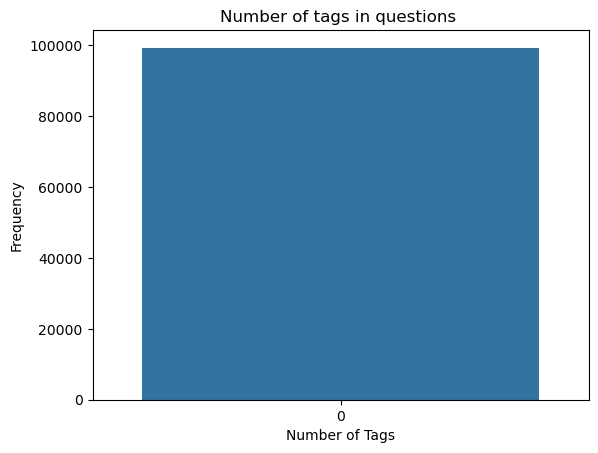

In [38]:
sns.countplot(df_train["tag_count"])
plt.title("Number of tags in questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Frequency")

Something looks odd about this

In [43]:
df_train['tag_count'].value_counts()

3    28432
2    26484
4    19043
1    13545
5    11858
Name: tag_count, dtype: int64

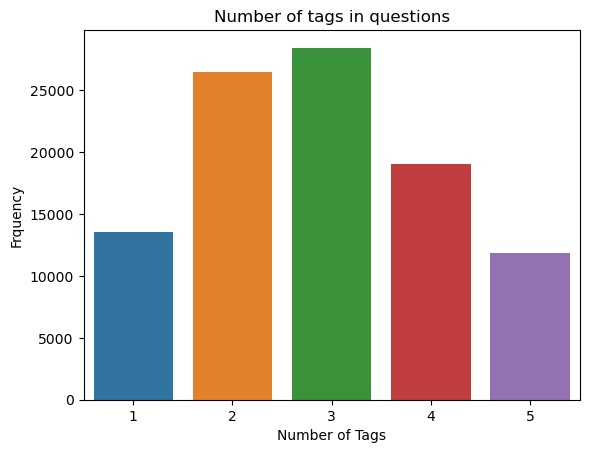

In [54]:
df_tag_freq = df_train['tag_count'].value_counts().reset_index().sort_values(by='index').rename(columns = {'index':'tag_count', 'tag_count':'tag_value_counts'})


plt.title('Number of tags in questions')
sns.barplot(data = df_tag_freq, x = 'tag_count', y = 'tag_value_counts')
plt.xlabel('Number of Tags')
plt.ylabel('Frquency')
plt.show()

This the work around we have done. 

#### Observations: 
1. Maximum number of tags in question: 5
2. Minimum number of tags in question: 1
3. Average number of tags in question: 2.89
4. Most of the questions have either 2 or 3 tags to work with.

### Total number of unique Tags

In [56]:
vectorizer = CountVectorizer(tokenizer = lambda x : x.split())
tag_bow = vectorizer.fit_transform(df_train['Tags'])

In [58]:
tag_bow.shape

(99362, 18636)

In [59]:
print("Number of questions :", tag_bow.shape[0])
print("Number of unique tags :", tag_bow.shape[1])

Number of questions : 99362
Number of unique tags : 18636


In [62]:
tags = vectorizer.get_feature_names_out()
print("Few tags :", tags[:10])

Few tags : ['.a' '.app' '.aspxauth' '.bash-profile' '.class-file' '.doc' '.each'
 '.emf' '.exe' '.htaccess']


In [63]:
df_train.head()

,level_0,index,Id,Title,Body,Tags,tag_count
0,0,63845,63846,"Flex Builder - Profiler - Can't run profiler ""...",<p>I use Flex Builder 4 Plugin on Eclipse 3.6....,actionscript flex4 flexbuilder profiler,4
1,1,3524474,3524475,How to read the index of the color table/palle...,<p>I have a grayscale bitmap with 8bit indexed...,android bitmap bitmapimage grayscale,4
2,2,942250,942251,Include files from context differents How do I...,<p>I have a relative path to another context o...,java servlets struts,3
3,3,1047314,1047315,Create deployable JRuby JAR file?,<p>I need to compile my JRuby application into...,jruby executable-jar,2
4,4,21366,21367,Biztalk 2009 install help,"<p>I try to install Biztalk2009, with SQL 2008...",biztalk,1


### Frequency of each tag

In [72]:
freq = tag_bow.sum(axis = 0).A1
tag_to_count_map = dict(zip(tags,freq))

In [65]:
freq

array([1, 1, 2, ..., 2, 1, 1])

In [80]:
print(f'Shape of Freqeuency: {freq.shape}')
print(f'Shape of Tags: {tags.shape}')


Shape of Freqeuency: (18636,)
Shape of Tags: (18636,)


In [82]:
list = []
for key, value in tag_to_count_map.items():
  list.append([key, value]) 

In [83]:
tag_df = pd.DataFrame(list, columns=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,1
1,.app,1
2,.aspxauth,2
3,.bash-profile,7
4,.class-file,1


Text(0, 0.5, 'Frequency')

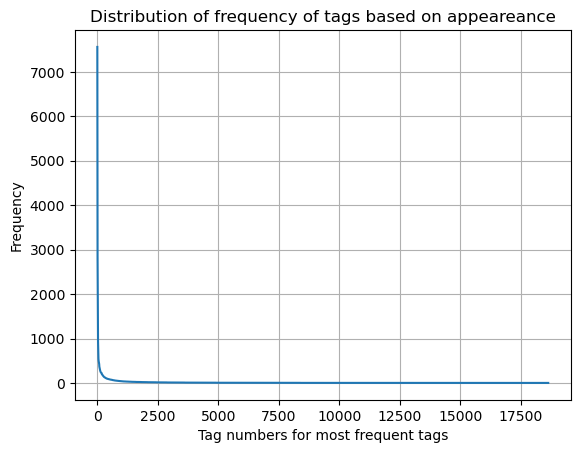

In [85]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
plt.plot(tag_df_sorted['Counts'].values)
plt.grid()
plt.title("Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

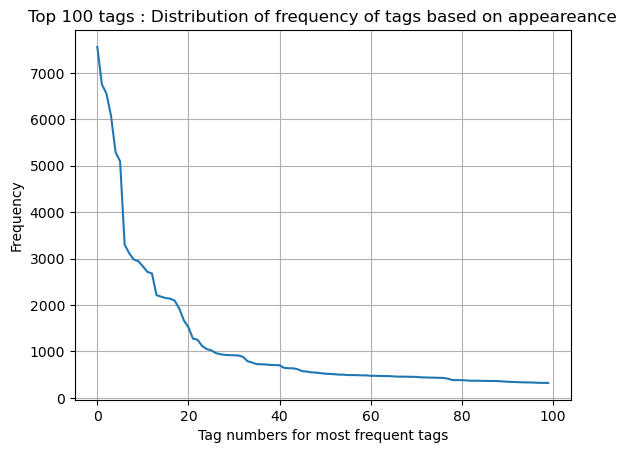

In [86]:
plt.plot(tag_df_sorted['Counts'][0:100].values)
plt.grid()
plt.title("Top 100 tags : Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")